#自作データセット

ジェスチャ：6種類

準拠するパラメータ：

・batch size = 128

・L2正則化の重み = 0.001

・学習率減衰：1~19 = 0.01, 20~39 = 0.001, 40~50 = 0.0001

・データ比：train:valid:test = 6:1:3

In [1]:
!nvidia-smi

Wed Dec 21 20:26:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8    21W / 350W |  10033MiB / 24576MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

dataset
バッチサイズ→128
テストデータ割合→10%

データセットの解凍

In [1]:
#import keras
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten
#from tensorflow.keras.layers.advanced_activations import PReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler #学習率減衰
from tensorflow.keras import regularizers #L2正則化
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import tensorflow as tf
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'#GPUのメモリ確保を制限

#乱数の設定
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(1)
np.random.seed(1)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

各種設定(データセットの指定など)

In [2]:
train_data_path = 'datasetHM' #データセットのフォルダ名
folder = os.listdir(train_data_path) #データセットのクラス名
print(folder)

class_number = len(folder)
print('分類するクラス数: ', class_number)

['1', '2', '3', '4', '5', '6']
分類するクラス数:  6


データセットの読み込み・準備

In [3]:
for index, name in enumerate(folder): #name:クラスフォルダ名, index:クラスに対応している変数
  read_data = train_data_path + '/' + name

  files = glob.glob(read_data + '/*.npy') #クラスごとのファイルすべてを格納
  print('--- 読み込んだデータセットは', read_data, 'です。')
  for i, file in enumerate(files):  #i:クラス内の各ファイルに対応している変数
    print('\r', read_data, ': ', i+1, '/', len(files), end='')
    array = np.load(file)
    np.save(file, array[:, :, :3])

--- 読み込んだデータセットは datasetHM/1 です。
 datasetHM/1 :  132966 / 132966--- 読み込んだデータセットは datasetHM/2 です。
 datasetHM/2 :  133494 / 133494--- 読み込んだデータセットは datasetHM/3 です。
 datasetHM/3 :  133599 / 133599--- 読み込んだデータセットは datasetHM/4 です。
 datasetHM/4 :  133457 / 133457--- 読み込んだデータセットは datasetHM/5 です。
 datasetHM/5 :  133423 / 133423--- 読み込んだデータセットは datasetHM/6 です。
 datasetHM/6 :  133997 / 133997

In [4]:
start = time.time()
X_image = []
Y_label = []
Xappend = X_image.append
Yappend = Y_label.append

#クラスごとのループ
for index, name in enumerate(folder): #name:クラスフォルダ名, index:クラスに対応している変数
  read_data = train_data_path + '/' + name

  files = glob.glob(read_data + '/*.npy') #クラスごとのファイルすべてを格納
  print('--- 読み込んだデータセットは', read_data, 'です。')

  #ファイルごとのループ
  for i, file in enumerate(files):  #i:クラス内の各ファイルに対応している変数
    print('\r', read_data, ': ', i+1, '/', len(files), end='')
    array = np.load(file)

    Xappend(array) #画像データをndarrayとして格納
    Yappend(index) #画像に対応したクラス(画像ラベル)を格納

  print(' --finish: ' + str(int((time.time()-start)/60)) + 'm' + str(int((time.time()-start))%60) + 's')
  
#データセット配列の設定
X_image = np.array(X_image) #データセット全体の画像行列データ＝入力データ
Y_label = np.array(Y_label) #データセット全体の画像ラベル

--- 読み込んだデータセットは datasetHM/1 です。
 datasetHM/1 :  132966 / 132966 --finish: 8m25s
--- 読み込んだデータセットは datasetHM/2 です。
 datasetHM/2 :  133494 / 133494 --finish: 16m38s
--- 読み込んだデータセットは datasetHM/3 です。
 datasetHM/3 :  133599 / 133599 --finish: 24m59s
--- 読み込んだデータセットは datasetHM/4 です。
 datasetHM/4 :  133457 / 133457 --finish: 33m11s
--- 読み込んだデータセットは datasetHM/5 です。
 datasetHM/5 :  133423 / 133423 --finish: 41m30s
--- 読み込んだデータセットは datasetHM/6 です。
 datasetHM/6 :  133997 / 133997 --finish: 50m6s


ch数(1~7)を指定したCNNモデル

In [5]:
tf.test.gpu_device_name()

#画像行列データを正規化
x_max = X_image.max()
x_min = X_image.min()
print(x_max, x_min)
scale = (x_max - x_min)/2
med = (x_max + x_min)/2
for i in range(len(X_image)):
    X_image[i, :, :, :] = (X_image[i, :, :, :] - med)/scale
print(X_image.max(), X_image.min())

Y_label = to_categorical(Y_label, class_number) #Kerasではクラスをベクトルで扱うらしい【おまじない】

#訓練データとテストデータを分割。
x_train, valid_images, y_train, valid_labels = train_test_split(X_image, Y_label, test_size=0.4, random_state=0)
x_valid, x_test, y_valid, y_test = train_test_split(valid_images, valid_labels, test_size=0.75, random_state=0)

print('train data size: ', len(x_train))
print('valid data size: ', len(x_valid))
print('test data size: ', len(x_test))

1.9138139918798982 -0.7468896857262057
1.0 -1.0
train data size:  480561
valid data size:  80093
test data size:  240282


In [16]:
#print(X_image.shape)

(800936, 25, 15, 8)


In [6]:
BATCH_SIZE = 128
image_size_x = 25 #画像サイズ
image_size_y = 15
channel = 3
epochnumber = 50
L2weight = 0.001 #Myo: 0.01, Nina: 0.001

#CNNアーキテクチャの設計
model = Sequential()

model.add(BatchNormalization(input_shape=(image_size_x, image_size_y, channel)))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))

model.add(GlobalAveragePooling2D())

model.add(Dense(class_number, activation='softmax', kernel_regularizer=regularizers.l2(L2weight)))

model.summary()

#学習率減衰の設定
def step_decay(epoch):
    x = 0.01
    if epoch >= 20: x = 0.001
    if epoch >= 40: x = 0.0001
    return x
lr_decay = LearningRateScheduler(step_decay)

model.compile(loss='categorical_crossentropy', #損失関数の設定
            optimizer=Adam(learning_rate=0.01), #最適化アルゴリズムの設定
            metrics=['accuracy'] #評価関数の設定
            )

start_time = time.time()

#可視化
history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=epochnumber, 
                    verbose=1, #学習過程を出力するかどうか
                    validation_data=(x_valid, y_valid), 
                    callbacks=[lr_decay] #学習率減衰の設定
                    )

print('Computation time: {0:.3f} sec'.format(time.time() - start_time))

model.save('model/EMGNet_HM.h5') #モデルの保存

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 25, 15, 3)        12        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 25, 15, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 25, 15, 16)        448       
                                                                 
 batch_normalization_1 (Batc  (None, 25, 15, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 25, 15, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 15, 32)        4

学習曲線の作図(保存したモデルを呼び出して実行)

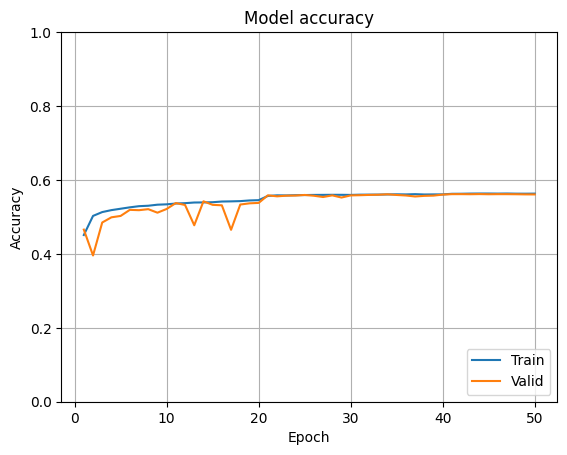

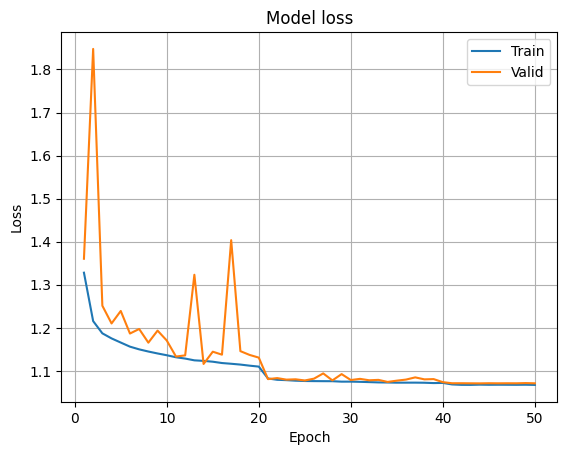

In [10]:
model = load_model('model/EMGNet_HM.h5')

#作図
x = range(1, epochnumber+1)
plt.plot(x, history.history['accuracy'])
plt.plot(x, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

plt.plot(x, history.history['loss'])
plt.plot(x, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
#plt.ylim(0, 8)
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

テスト・混同行列の作成(参考：https://newtechnologylifestyle.net/keras_fashion-mnist/)(https://kinpatucom821.hatenablog.com/entry/2018/08/30/215419)

7509/7509 [==============================] - 11s 1ms/step
Confusion matrix, without normalization
[[33989  3148   476  1727   451    84]
 [ 2940 27429  4281  1440  3169   859]
 [  630  5375 16540  5021  5066  7371]
 [ 2239  1478  3976 22934  3786  6008]
 [ 1023  6882  7342  7177  9700  7705]
 [  128  1435  6330  4360  3313 24470]]


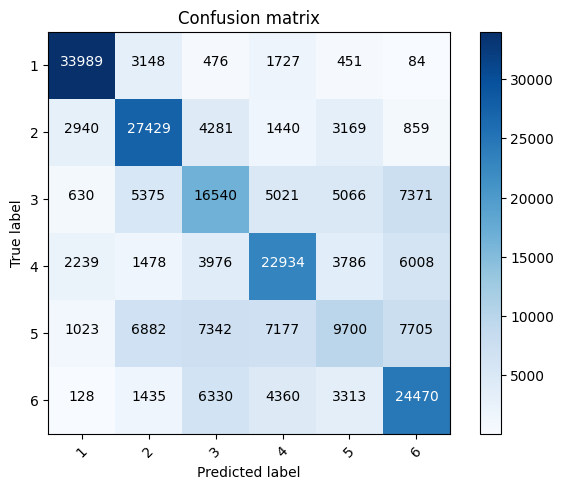

Loss: 1.0720974206924438 （損失関数値 - 0に近いほど正解に近い）
Accuracy: 56.209784746170044 % （精度 - 100% に近いほど正解に近い）


In [11]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

pred_y = model.predict(x_test)
pred_y_classes = np.argmax(pred_y,axis = 1) 
tue_y= np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(tue_y, pred_y_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(1, 7)) 
plt.show()

score = model.evaluate(x_test, y_test, verbose=0)
print('Loss:', score[0], '（損失関数値 - 0に近いほど正解に近い）') 
print('Accuracy:', score[1] * 100, '%', '（精度 - 100% に近いほど正解に近い）') 

In [14]:
print(confusion_mtx)

[[33989  3148   476  1727   451    84]
 [ 2940 27429  4281  1440  3169   859]
 [  630  5375 16540  5021  5066  7371]
 [ 2239  1478  3976 22934  3786  6008]
 [ 1023  6882  7342  7177  9700  7705]
 [  128  1435  6330  4360  3313 24470]]


Normalized confusion matrix
[[0.85238871 0.07894671 0.0119373  0.04331034 0.01131034 0.00210658]
 [0.07328381 0.68370806 0.1067102  0.03589411 0.07899197 0.02141184]
 [0.01574882 0.13436492 0.41346899 0.12551559 0.1266405  0.18426118]
 [0.055392   0.03656515 0.09836471 0.56737834 0.09366418 0.14863561]
 [0.0256848  0.17278867 0.18433805 0.18019534 0.24354114 0.19345201]
 [0.00319712 0.03584274 0.1581077  0.10890199 0.08275052 0.61119992]]


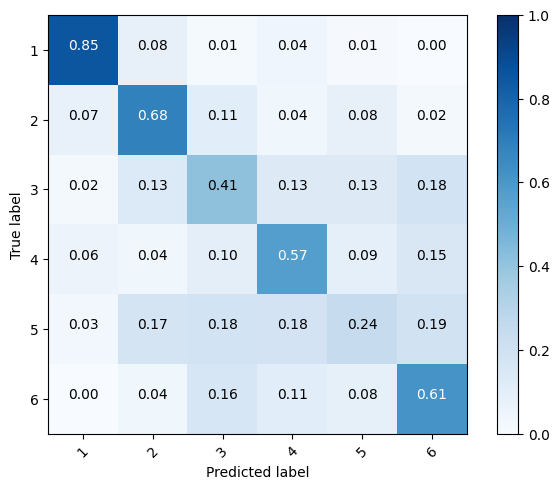

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

#model = load_model('model/EMGNet_Nina_B6_1.h5')

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = [[33989,  3148,   476,  1727,   451,    84],
                 [ 2940, 27429,  4281,  1440,  3169,   859],
                 [  630,  5375, 16540,  5021,  5066,  7371],
                 [ 2239,  1478,  3976, 22934,  3786,  6008],
                 [ 1023,  6882,  7342,  7177,  9700,  7705],
                 [  128,  1435,  6330,  4360,  3313, 24470]]
mtx = np.array(confusion_mtx)
#mtx = mtx[[5,1,3,0,2,4]]
#mtx = mtx[:,[5,1,3,0,2,4]]

plot_confusion_matrix(mtx, classes = range(1, 7)) 
plt.show()